## featureCounts from Rsubread package to generate counts matrix

code to install Rsubread 

```BiocManager::install("Rsubread") ```

only need to install once, then just load everytime

In [1]:
library(Rsubread)

following [example script](https://www.rdocumentation.org/packages/Rsubread/versions/1.22.2/topics/featureCounts)

first need to create a variable that contains all of the SAM files for input of featureCounts

In [2]:
# setting variable files to include all SAM files
setwd('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_methyl_assembly/assembly_pipeline_files/sam_files')
files <- c('2018--BBB-WBO-B21-CV_alignment.sam','2018--BPO-BPO-O16-CV_alignment.sam','2018--WBR-BBY-W25-CV_alignment.sam',
'2018--BBB-WBV-B70-CV_alignment.sam',  '2018--BPR-BPG-O38-CV_alignment.sam',  '2018--WBV-WBO-W23-CV_alignment.sam',
'2018--BBO-BBO-B16-CV_alignment.sam',  '2018--BPR-BPR-O02-CV_alignment.sam',  '2018--WBV-WBR-W12-CV_alignment.sam',
'2018--BBO-BBY-B27-CV_alignment.sam',  '2018--BPY-BPG-O42-CV_alignment.sam',  '2018--WBY-BBV-W65-CV_alignment.sam',
'2018--BBO-WBO-B16-CV_alignment.sam',  '2018--BPY-BPY-O29-CV_alignment.sam',  '2018--WBY-BBY-W30-CV_alignment.sam',
'2018--BBO-WBV-B64-CV_alignment.sam',  '2018--WBB-WBV-W69-CV_alignment.sam',  '2018--WPB-BPG-G45-CV_alignment.sam',
'2018--BBR-BBB-B50-CV_alignment.sam',  '2018--WBG-BBB-W56-CV_alignment.sam',  '2018--WPO-BPO-G16-CV_alignment.sam',
'2018--BBR-BBG-B38-CV_alignment.sam',  '2018--WBG-WBG-W44-CV_alignment.sam',  '2018--WPO-BPY-G28-CV_alignment.sam',
'2018--BBR-BBY-B26-CV_alignment.sam',  '2018--WBO-BBR-W03-CV_alignment.sam',  '2018--WPR-BPY-G25-CV_alignment.sam',
'2018--BBY-WBG-B42-CV_alignment.sam',  '2018--WBO-WBV-W64-CV_alignment.sam',  '2018--WPV-BPR-G11-CV_alignment.sam')
gtf_file <- "/project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/genomic.gtf"

I was getting an error in my featureCounts script for a while about it not being able to read the 9th column to find gene_id, even though it was there. After some googling, found out that featureCounts will not work if there are empty entries for gene_id - have to remove any row that doesn't have an input for gene_id

#### removing rows that don't have gene_id entries 
**RUN THIS CODE IN COMMAND LINE**

```grep 'gene_id ""' genomic.gtf ```

```grep -v 'gene_id ""' genomic.gtf > fixed_CV_annotation.gtf```

In [3]:
# now resetting gtf_file variable
gtf_file <- "/project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/fixed_CV_annotation.gtf"

#### featureCounts on Meta-Features

running actual featureCounts function on SAM files - counts for meta-features (e.g. genes)

can skip the two code blocks that actually run featureCounts -> since now we have the files and can just read them in

In [4]:
## CAN SKIP AFTER FIRST TIME RUNNING ##
counts <- featureCounts(files, # SAM or BAM format - automatically detects
              
              # annotation
              annot.ext = gtf_file, # input of annotation GTF file
              isGTFAnnotationFile=TRUE, # input of annotation file is in GTF format
              GTF.featureType="exon", # feature type used to select rows in GTF annotation
              #GTF.attrType="gene_id", # group features (e.g. exons) into meta-features (e.g. genes)
              
              # level of summarization
              useMetaFeatures=TRUE, # read summarization performed at meta-feature level
              # if FALSE, read summarization performed at feature level (e.g. exons)
              
              # parameters specific to paired end reads
              isPairedEnd=TRUE,
              countChimericFragments=TRUE,
              autosort=TRUE)


        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
       Rsubread 2.16.1

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 30 SAM files                                     ||
||                                                                            ||
||                           2018--BBB-WBO-B21-CV_alignment.sam               ||
||                           2018--BPO-BPO-O16-CV_alignment.sam               ||
||                           2018--WBR-BBY-W25-CV_al

generally get about 50% of reads that match up to gene names for each sample

writing results to text file

In [5]:
## again can skip after running the first time ##
write.table(
  x=data.frame(counts$annotation[,c("GeneID","Length")],
    counts$counts,
    stringsAsFactors=FALSE),
  file="counts.txt",
  quote=FALSE,
  sep="\t",
  row.names=FALSE)

reading in the text file and checking how it looks

In [2]:
metaf_counts <- read.table('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_methyl_assembly/assembly_pipeline_files/sam_files/fc_counts.txt', header=TRUE)
dim(metaf_counts) # 38,828 genes total
head(metaf_counts)

[1] 38828    32

,GeneID,Length,X2018..BBB.WBO.B21.CV_alignment.sam,X2018..BPO.BPO.O16.CV_alignment.sam,X2018..WBR.BBY.W25.CV_alignment.sam,X2018..BBB.WBV.B70.CV_alignment.sam,X2018..BPR.BPG.O38.CV_alignment.sam,X2018..WBV.WBO.W23.CV_alignment.sam,X2018..BBO.BBO.B16.CV_alignment.sam,X2018..BPR.BPR.O02.CV_alignment.sam,⋯,X2018..WPO.BPO.G16.CV_alignment.sam,X2018..BBR.BBG.B38.CV_alignment.sam,X2018..WBG.WBG.W44.CV_alignment.sam,X2018..WPO.BPY.G28.CV_alignment.sam,X2018..BBR.BBY.B26.CV_alignment.sam,X2018..WBO.BBR.W03.CV_alignment.sam,X2018..WPR.BPY.G25.CV_alignment.sam,X2018..BBY.WBG.B42.CV_alignment.sam,X2018..WBO.WBV.W64.CV_alignment.sam,X2018..WPV.BPR.G11.CV_alignment.sam
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,LOC111116054,118,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
2,LOC111126949,2254,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,LOC111110729,2083,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,LOC111112434,1023,0,0,0,0,0,0,0,2,⋯,0,0,0,0,0,0,0,0,0,0
5,LOC111120752,1070,2,1,0,2,0,0,0,2,⋯,0,0,0,1,1,0,1,0,1,0
6,LOC111128944,1773,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


looks like this is counts for meta-features and not features -> because of this:

Features : 726075                                                       ||
Meta-features : 38828

doing this for features instead of meta-features - had accidentally set useMetaFeatures=FALSE

#### featureCounts on Features

In [7]:
## again can skip after running for the first time ##
counts_features <- featureCounts(files, # SAM or BAM format - automatically detects
              
              # annotation
              annot.ext = gtf_file, # input of annotation GTF file
              isGTFAnnotationFile=TRUE, # input of annotation file is in GTF format
              GTF.featureType="exon", # feature type used to select rows in GTF annotation
              #GTF.attrType="gene_id", # group features (e.g. exons) into meta-features (e.g. genes)
              
              # level of summarization
              useMetaFeatures=FALSE, # read summarization performed at meta-feature level
              # if FALSE, read summarization performed at feature level (e.g. exons)
              
              # parameters specific to paired end reads
              isPairedEnd=TRUE,
              countChimericFragments=TRUE,
              autosort=TRUE)


        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
       Rsubread 2.16.1

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 30 SAM files                                     ||
||                                                                            ||
||                           2018--BBB-WBO-B21-CV_alignment.sam               ||
||                           2018--BPO-BPO-O16-CV_alignment.sam               ||
||                           2018--WBR-BBY-W25-CV_al

In [8]:
# can skip after running for the first time
# writes the output of featureCounts into a txt file in the directory
write.table(
  x=data.frame(counts_features$annotation[,c("GeneID","Length")],
    counts_features$counts,
    stringsAsFactors=FALSE),
  file="fc_feature_counts.txt",
  quote=FALSE,
  sep="\t",
  row.names=FALSE)

In [3]:
# reading in the txt file as a data frame
feature_counts <- read.table('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_methyl_assembly/assembly_pipeline_files/sam_files/fc_feature_counts.txt', header=TRUE)
dim(feature_counts) # 726,075 features total
head(feature_counts,50)

[1] 726075     32

,GeneID,Length,X2018..BBB.WBO.B21.CV_alignment.sam,X2018..BPO.BPO.O16.CV_alignment.sam,X2018..WBR.BBY.W25.CV_alignment.sam,X2018..BBB.WBV.B70.CV_alignment.sam,X2018..BPR.BPG.O38.CV_alignment.sam,X2018..WBV.WBO.W23.CV_alignment.sam,X2018..BBO.BBO.B16.CV_alignment.sam,X2018..BPR.BPR.O02.CV_alignment.sam,⋯,X2018..WPO.BPO.G16.CV_alignment.sam,X2018..BBR.BBG.B38.CV_alignment.sam,X2018..WBG.WBG.W44.CV_alignment.sam,X2018..WPO.BPY.G28.CV_alignment.sam,X2018..BBR.BBY.B26.CV_alignment.sam,X2018..WBO.BBR.W03.CV_alignment.sam,X2018..WPR.BPY.G25.CV_alignment.sam,X2018..BBY.WBG.B42.CV_alignment.sam,X2018..WBO.WBV.W64.CV_alignment.sam,X2018..WPV.BPR.G11.CV_alignment.sam
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,LOC111116054,26,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
2,LOC111116054,54,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,LOC111116054,38,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,LOC111126949,113,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,LOC111126949,1034,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,LOC111126949,152,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
7,LOC111126949,589,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
8,LOC111126949,366,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
9,LOC111110729,29,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


so now have new counts matrix that contains counts of reads for all features (*not* meta-features) 

next step is to run DESeq on this

#### formatting and cleaning dataframes before analysis

In [4]:
# read in meta data of samples
meta_data <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/counts_and_meta/CV_CE18_meta.csv')
head(meta_data)

,sample_ID,unique_ID,T1_code,T2_code,ID_code,T1_oxygen,T1_temp,Tank1,T2_oxygen,T2_temp,Tank2,Phase1,Phase2
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,2018--BBB-WBO-B21-CV,BBB-WBO-B21,BBB,WBO,B21,hypoxic,ambient,B,normoxic,ambient,O,hypoxic,control
2,2018--BBB-WBV-B70-CV,BBB-WBV-B70,BBB,WBV,B70,hypoxic,ambient,B,normoxic,ambient,V,hypoxic,control
3,2018--BBO-BBO-B16-CV,BBO-BBO-B16,BBO,BBO,B16,hypoxic,ambient,O,hypoxic,ambient,O,hypoxic,hypoxic
4,2018--BBO-BBY-B27-CV,BBO-BBY-B27,BBO,BBY,B27,hypoxic,ambient,O,hypoxic,ambient,Y,hypoxic,hypoxic
5,2018--BBO-WBO-B16-CV,BBO-WBO-B16,BBO,WBO,B16,hypoxic,ambient,O,normoxic,ambient,O,hypoxic,control
6,2018--BBO-WBV-B64-CV,BBO-WBV-B64,BBO,WBV,B64,hypoxic,ambient,O,normoxic,ambient,V,hypoxic,control


**working with the counts matrix of features**

In [5]:
# clean up column names of the feature counts matrix
#colnames(feature_counts) = c('GeneID','Length', meta_data$unique_ID)
head(colnames(feature_counts))

head(meta_data$unique_ID)

## THESE DO NOT MATCH - CANNOT SIMPLY ASSIGN!! ##

[1] "GeneID"                              "Length"                             
[3] "X2018..BBB.WBO.B21.CV_alignment.sam" "X2018..BPO.BPO.O16.CV_alignment.sam"
[5] "X2018..WBR.BBY.W25.CV_alignment.sam" "X2018..BBB.WBV.B70.CV_alignment.sam"

[1] "BBB-WBO-B21" "BBB-WBV-B70" "BBO-BBO-B16" "BBO-BBY-B27" "BBO-WBO-B16"
[6] "BBO-WBV-B64"

In [6]:
# cleaning up the column names of feature_counts 
# code generated with ChatGPT

# removing the extra info from the file name
cleaned_column_names <- gsub("^X2018\\.\\.", "", gsub("\\.CV_alignment\\.sam$", "", colnames(feature_counts)))
head(cleaned_column_names)

# replace the '.' with '-'
cleaned_column_names2 <- gsub('\\.', "-", cleaned_column_names)
head(cleaned_column_names2)

# now assigning to the columns
colnames(feature_counts) = cleaned_column_names2
head(feature_counts)

[1] "GeneID"      "Length"      "BBB.WBO.B21" "BPO.BPO.O16" "WBR.BBY.W25"
[6] "BBB.WBV.B70"

[1] "GeneID"      "Length"      "BBB-WBO-B21" "BPO-BPO-O16" "WBR-BBY-W25"
[6] "BBB-WBV-B70"

,GeneID,Length,BBB-WBO-B21,BPO-BPO-O16,WBR-BBY-W25,BBB-WBV-B70,BPR-BPG-O38,WBV-WBO-W23,BBO-BBO-B16,BPR-BPR-O02,⋯,WPO-BPO-G16,BBR-BBG-B38,WBG-WBG-W44,WPO-BPY-G28,BBR-BBY-B26,WBO-BBR-W03,WPR-BPY-G25,BBY-WBG-B42,WBO-WBV-W64,WPV-BPR-G11
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,LOC111116054,26,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
2,LOC111116054,54,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,LOC111116054,38,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,LOC111126949,113,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,LOC111126949,1034,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,LOC111126949,152,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [7]:
# removing the legnth column
feature_counts2 <- feature_counts[,-2]
head(feature_counts2)

,GeneID,BBB-WBO-B21,BPO-BPO-O16,WBR-BBY-W25,BBB-WBV-B70,BPR-BPG-O38,WBV-WBO-W23,BBO-BBO-B16,BPR-BPR-O02,WBV-WBR-W12,⋯,WPO-BPO-G16,BBR-BBG-B38,WBG-WBG-W44,WPO-BPY-G28,BBR-BBY-B26,WBO-BBR-W03,WPR-BPY-G25,BBY-WBG-B42,WBO-WBV-W64,WPV-BPR-G11
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,LOC111116054,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
2,LOC111116054,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,LOC111116054,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,LOC111126949,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,LOC111126949,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,LOC111126949,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


in order to do DESeq analysis -> need the number of columns of the counts matrix to equal the number of rows in the meta data 

the first time I did DESeq - each row of the counts matrix was a unique gene (meta-feature), so made it easy to set that as the rowname - now, each row is a feature so there are multiple rows with the same gene name - can arbitrarily label them a number, but might make it difficult later to match up the gene/feature names...

In [8]:
length(colnames(feature_counts2)) #31
length(rownames(meta_data)) #30
# number of columns in feature_counts != number of rows in meta_data

[1] 31

[1] 30

In [9]:
# remove gene name column
fc_matrix <- feature_counts2[,-1]
head(fc_matrix)

,BBB-WBO-B21,BPO-BPO-O16,WBR-BBY-W25,BBB-WBV-B70,BPR-BPG-O38,WBV-WBO-W23,BBO-BBO-B16,BPR-BPR-O02,WBV-WBR-W12,BBO-BBY-B27,⋯,WPO-BPO-G16,BBR-BBG-B38,WBG-WBG-W44,WPO-BPY-G28,BBR-BBY-B26,WBO-BBR-W03,WPR-BPY-G25,BBY-WBG-B42,WBO-WBV-W64,WPV-BPR-G11
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [10]:
length(colnames(fc_matrix)) #30
length(rownames(meta_data)) #30

[1] 30

[1] 30

**working with the counts matrix for META features (genes)**

In [11]:
# removing the length column
meta_counts <- metaf_counts[,-2]
head(meta_counts)

,GeneID,X2018..BBB.WBO.B21.CV_alignment.sam,X2018..BPO.BPO.O16.CV_alignment.sam,X2018..WBR.BBY.W25.CV_alignment.sam,X2018..BBB.WBV.B70.CV_alignment.sam,X2018..BPR.BPG.O38.CV_alignment.sam,X2018..WBV.WBO.W23.CV_alignment.sam,X2018..BBO.BBO.B16.CV_alignment.sam,X2018..BPR.BPR.O02.CV_alignment.sam,X2018..WBV.WBR.W12.CV_alignment.sam,⋯,X2018..WPO.BPO.G16.CV_alignment.sam,X2018..BBR.BBG.B38.CV_alignment.sam,X2018..WBG.WBG.W44.CV_alignment.sam,X2018..WPO.BPY.G28.CV_alignment.sam,X2018..BBR.BBY.B26.CV_alignment.sam,X2018..WBO.BBR.W03.CV_alignment.sam,X2018..WPR.BPY.G25.CV_alignment.sam,X2018..BBY.WBG.B42.CV_alignment.sam,X2018..WBO.WBV.W64.CV_alignment.sam,X2018..WPV.BPR.G11.CV_alignment.sam
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,LOC111116054,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
2,LOC111126949,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,LOC111110729,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,LOC111112434,0,0,0,0,0,0,0,2,0,⋯,0,0,0,0,0,0,0,0,0,0
5,LOC111120752,2,1,0,2,0,0,0,2,0,⋯,0,0,0,1,1,0,1,0,1,0
6,LOC111128944,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [12]:
# removing the extra info from the file name
cleaned_column_names <- gsub("^X2018\\.\\.", "", gsub("\\.CV_alignment\\.sam$", "", colnames(meta_counts)))
head(cleaned_column_names)

# replace the '.' with '-'
cleaned_column_names2 <- gsub('\\.', "-", cleaned_column_names)
head(cleaned_column_names2)

# now assigning to the columns
colnames(meta_counts) = cleaned_column_names2
head(meta_counts)

[1] "GeneID"      "BBB.WBO.B21" "BPO.BPO.O16" "WBR.BBY.W25" "BBB.WBV.B70"
[6] "BPR.BPG.O38"

[1] "GeneID"      "BBB-WBO-B21" "BPO-BPO-O16" "WBR-BBY-W25" "BBB-WBV-B70"
[6] "BPR-BPG-O38"

,GeneID,BBB-WBO-B21,BPO-BPO-O16,WBR-BBY-W25,BBB-WBV-B70,BPR-BPG-O38,WBV-WBO-W23,BBO-BBO-B16,BPR-BPR-O02,WBV-WBR-W12,⋯,WPO-BPO-G16,BBR-BBG-B38,WBG-WBG-W44,WPO-BPY-G28,BBR-BBY-B26,WBO-BBR-W03,WPR-BPY-G25,BBY-WBG-B42,WBO-WBV-W64,WPV-BPR-G11
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,LOC111116054,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
2,LOC111126949,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,LOC111110729,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,LOC111112434,0,0,0,0,0,0,0,2,0,⋯,0,0,0,0,0,0,0,0,0,0
5,LOC111120752,2,1,0,2,0,0,0,2,0,⋯,0,0,0,1,1,0,1,0,1,0
6,LOC111128944,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [13]:
# setting the gene ID names as the rownames so we can pull out the ID later after analysis
rownames(meta_counts) <- meta_counts$GeneID
head(meta_counts)

,GeneID,BBB-WBO-B21,BPO-BPO-O16,WBR-BBY-W25,BBB-WBV-B70,BPR-BPG-O38,WBV-WBO-W23,BBO-BBO-B16,BPR-BPR-O02,WBV-WBR-W12,⋯,WPO-BPO-G16,BBR-BBG-B38,WBG-WBG-W44,WPO-BPY-G28,BBR-BBY-B26,WBO-BBR-W03,WPR-BPY-G25,BBY-WBG-B42,WBO-WBV-W64,WPV-BPR-G11
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
LOC111116054,LOC111116054,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
LOC111126949,LOC111126949,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
LOC111110729,LOC111110729,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
LOC111112434,LOC111112434,0,0,0,0,0,0,0,2,0,⋯,0,0,0,0,0,0,0,0,0,0
LOC111120752,LOC111120752,2,1,0,2,0,0,0,2,0,⋯,0,0,0,1,1,0,1,0,1,0
LOC111128944,LOC111128944,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [14]:
# removing the geneID
meta_counts2 <- meta_counts[,-1]
head(meta_counts2)

,BBB-WBO-B21,BPO-BPO-O16,WBR-BBY-W25,BBB-WBV-B70,BPR-BPG-O38,WBV-WBO-W23,BBO-BBO-B16,BPR-BPR-O02,WBV-WBR-W12,BBO-BBY-B27,⋯,WPO-BPO-G16,BBR-BBG-B38,WBG-WBG-W44,WPO-BPY-G28,BBR-BBY-B26,WBO-BBR-W03,WPR-BPY-G25,BBY-WBG-B42,WBO-WBV-W64,WPV-BPR-G11
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
LOC111116054,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
LOC111126949,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
LOC111110729,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
LOC111112434,0,0,0,0,0,0,0,2,0,0,⋯,0,0,0,0,0,0,0,0,0,0
LOC111120752,2,1,0,2,0,0,0,2,0,0,⋯,0,0,0,1,1,0,1,0,1,0
LOC111128944,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [15]:
# double checking that the number of columns in the counts matrix matches the rows in the meta data
dim(meta_counts2) # 30 columns
dim(meta_data) # 30 rows

[1] 38828    30

[1] 30 13

#### ALSO - samples must be in the same order for the counts matrix AND meta data

In [18]:
# setting unique_ID as the row name
rownames(meta_data) <- meta_data$unique_ID
head(meta_data)

,sample_ID,unique_ID,T1_code,T2_code,ID_code,T1_oxygen,T1_temp,Tank1,T2_oxygen,T2_temp,Tank2,Phase1,Phase2
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
BBB-WBO-B21,2018--BBB-WBO-B21-CV,BBB-WBO-B21,BBB,WBO,B21,hypoxic,ambient,B,normoxic,ambient,O,hypoxic,control
BBB-WBV-B70,2018--BBB-WBV-B70-CV,BBB-WBV-B70,BBB,WBV,B70,hypoxic,ambient,B,normoxic,ambient,V,hypoxic,control
BBO-BBO-B16,2018--BBO-BBO-B16-CV,BBO-BBO-B16,BBO,BBO,B16,hypoxic,ambient,O,hypoxic,ambient,O,hypoxic,hypoxic
BBO-BBY-B27,2018--BBO-BBY-B27-CV,BBO-BBY-B27,BBO,BBY,B27,hypoxic,ambient,O,hypoxic,ambient,Y,hypoxic,hypoxic
BBO-WBO-B16,2018--BBO-WBO-B16-CV,BBO-WBO-B16,BBO,WBO,B16,hypoxic,ambient,O,normoxic,ambient,O,hypoxic,control
BBO-WBV-B64,2018--BBO-WBV-B64-CV,BBO-WBV-B64,BBO,WBV,B64,hypoxic,ambient,O,normoxic,ambient,V,hypoxic,control


In [20]:
# checking if samples are in the right order
colnames(meta_counts2)
rownames(meta_data)
all(rownames(meta_data) == colnames(meta_counts2)) # FALSE - not in the same order

[1] "BBB-WBO-B21" "BPO-BPO-O16" "WBR-BBY-W25" "BBB-WBV-B70" "BPR-BPG-O38"
 [6] "WBV-WBO-W23" "BBO-BBO-B16" "BPR-BPR-O02" "WBV-WBR-W12" "BBO-BBY-B27"
[11] "BPY-BPG-O42" "WBY-BBV-W65" "BBO-WBO-B16" "BPY-BPY-O29" "WBY-BBY-W30"
[16] "BBO-WBV-B64" "WBB-WBV-W69" "WPB-BPG-G45" "BBR-BBB-B50" "WBG-BBB-W56"
[21] "WPO-BPO-G16" "BBR-BBG-B38" "WBG-WBG-W44" "WPO-BPY-G28" "BBR-BBY-B26"
[26] "WBO-BBR-W03" "WPR-BPY-G25" "BBY-WBG-B42" "WBO-WBV-W64" "WPV-BPR-G11"

[1] "BBB-WBO-B21" "BBB-WBV-B70" "BBO-BBO-B16" "BBO-BBY-B27" "BBO-WBO-B16"
 [6] "BBO-WBV-B64" "BBR-BBB-B50" "BBR-BBG-B38" "BBR-BBY-B26" "BBY-WBG-B42"
[11] "BPO-BPO-O16" "BPR-BPG-O38" "BPR-BPR-O02" "BPY-BPG-O42" "BPY-BPY-O29"
[16] "WBB-WBV-W69" "WBG-BBB-W56" "WBG-WBG-W44" "WBO-BBR-W03" "WBO-WBV-W64"
[21] "WBR-BBY-W25" "WBV-WBO-W23" "WBV-WBR-W12" "WBY-BBV-W65" "WBY-BBY-W30"
[26] "WPB-BPG-G45" "WPO-BPO-G16" "WPO-BPY-G28" "WPR-BPY-G25" "WPV-BPR-G11"

[1] FALSE

In [21]:
fc_meta <- meta_counts2[,rownames(meta_data)]
all(rownames(meta_data) == colnames(fc_meta))

[1] TRUE

In [35]:
# doing the same thing for features
fc_matrix <- fc_matrix[,rownames(meta_data)]
all(rownames(meta_data) == colnames(fc_matrix))

[1] TRUE

#### data frames/variables moving forward:
- **meta_data**: meta info on samples including treatment info
- **fc_meta**: counts matrix for META features (genes)
- **fc_matrix**: counts matrix for features (like exons)

### running DESeq2 **on FEATURES (e.g. exons)**

In [24]:
# installing packages needed for analysis
library(DESeq2)
library(EnhancedVolcano)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb

Loa

#### effects of phase 1, ignoring phase 2

In [37]:
# creating DESeq2 objext from the matrix, with the design = treatment (which has both phase 1 and phase 2 variables)
p1_dds <- DESeqDataSetFromMatrix(countData = fc_matrix,
                              colData = meta_data, 
                              design = ~ Phase1)
p1_dds=DESeq(p1_dds)
resultsNames(p1_dds)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 709 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "Intercept"              "Phase1_control_vs_both" "Phase1_hypoxic_vs_both"
[4] "Phase1_warm_vs_both"

In [38]:
# specify contrasts (what treatments to compare)
contrast1 <- c("Phase1", "hypoxic", "control")
contrast2 <- c("Phase1", "both", "control")
contrast3 <- c("Phase1", "warm", "control")

In [39]:
# storing results in variables to call for EnhancedVolcano 

# Phase 1 hypoxic vs. control
results1 <- results(p1_dds, contrast = contrast1, alpha=0.05)

# Phase 1 both vs. control
results2 <- results(p1_dds, contrast = contrast2, alpha=0.05)

# Phase 1 warm vs. control
results3 <- results(p1_dds, contrast = contrast3, alpha=0.05)


out of 37620 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 1, 0.0027%
LFC < 0 (down)     : 1, 0.0027%
outliers [1]       : 288, 0.77%
low counts [2]     : 10, 0.027%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



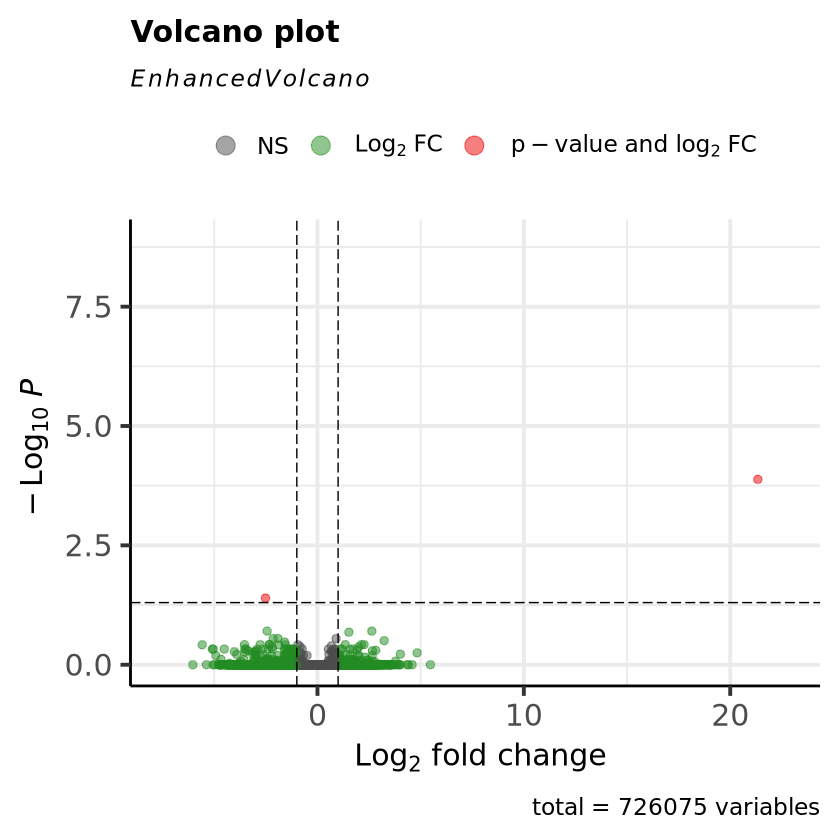

In [40]:
# phase 1 hypoxic vs. control
summary(results1)

EnhancedVolcano(results1, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)


out of 37620 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 288, 0.77%
low counts [2]     : 10, 0.027%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



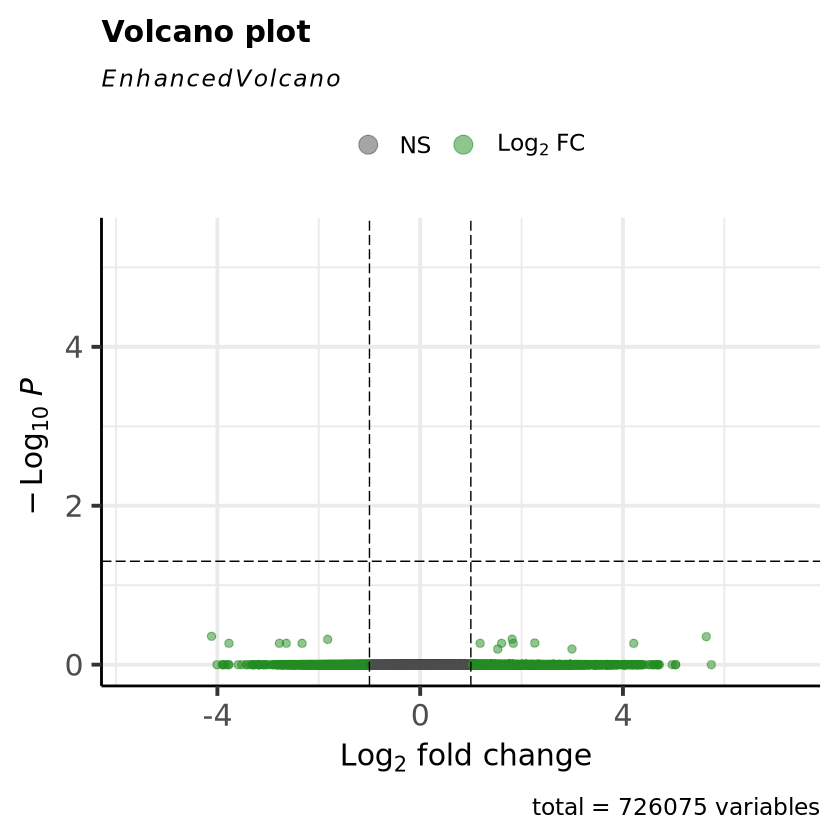

In [41]:
# phase 1 both vs. control
summary(results2)

EnhancedVolcano(results2, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)


out of 37620 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 316, 0.84%
LFC < 0 (down)     : 1, 0.0027%
outliers [1]       : 288, 0.77%
low counts [2]     : 932, 2.5%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



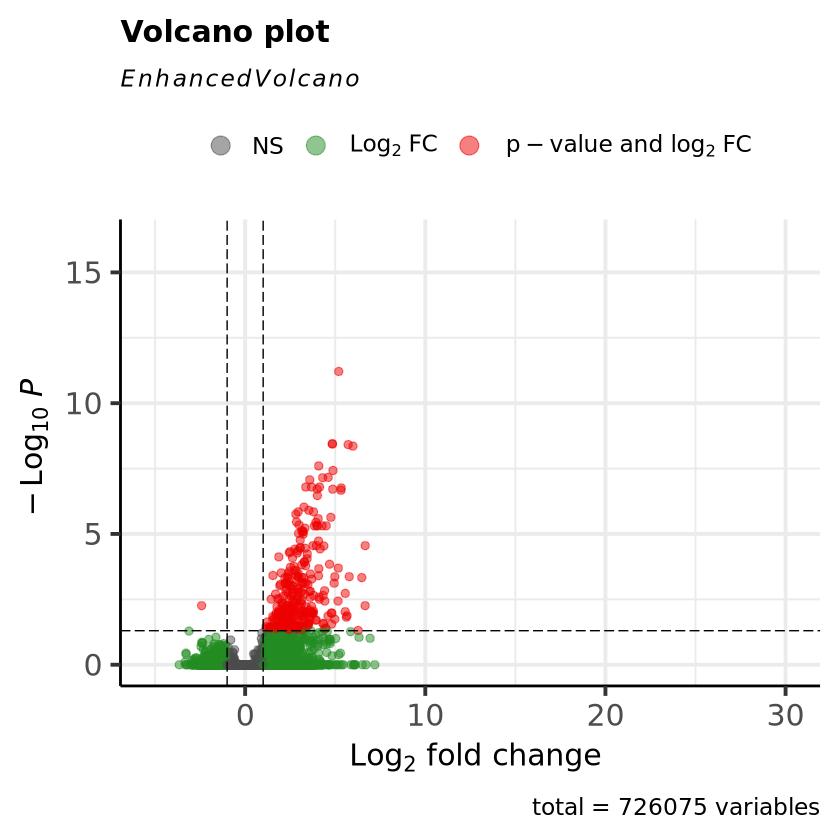

In [42]:
# phase 1 warm vs. control
summary(results3)

EnhancedVolcano(results3, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

only seeing about 300 differentially methylated FEATURES (e.g. exons) - not the same as what we were looking at with htseq-counts

#### Effects of Phase 2, ignoring Phase 1

In [28]:
# creating DESeq2 objext from the matrix, with the design = treatment (which has both phase 1 and phase 2 variables)
p2_dds <- DESeqDataSetFromMatrix(countData = fc_matrix,
                              colData = meta_data, 
                              design = ~ Phase2)
p2_dds=DESeq(p2_dds)
resultsNames(p2_dds)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 1034 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "Intercept"              "Phase2_control_vs_both" "Phase2_hypoxic_vs_both"

In [29]:
# specify contrasts (what treatments to compare)
contrast4 <- c("Phase2", "both", "control")
contrast5 <- c("Phase2", "hypoxic", "both")

In [30]:
# storing results in variables to call for EnhancedVolcano 

# Phase 2 both vs. control
results4 <- results(p2_dds, contrast = contrast4, alpha=0.05)

# Phase 2 hypoxic vs. both
results5 <- results(p2_dds, contrast = contrast5, alpha=0.05)


out of 37610 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 1, 0.0027%
LFC < 0 (down)     : 2, 0.0053%
outliers [1]       : 0, 0%
low counts [2]     : 20, 0.053%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



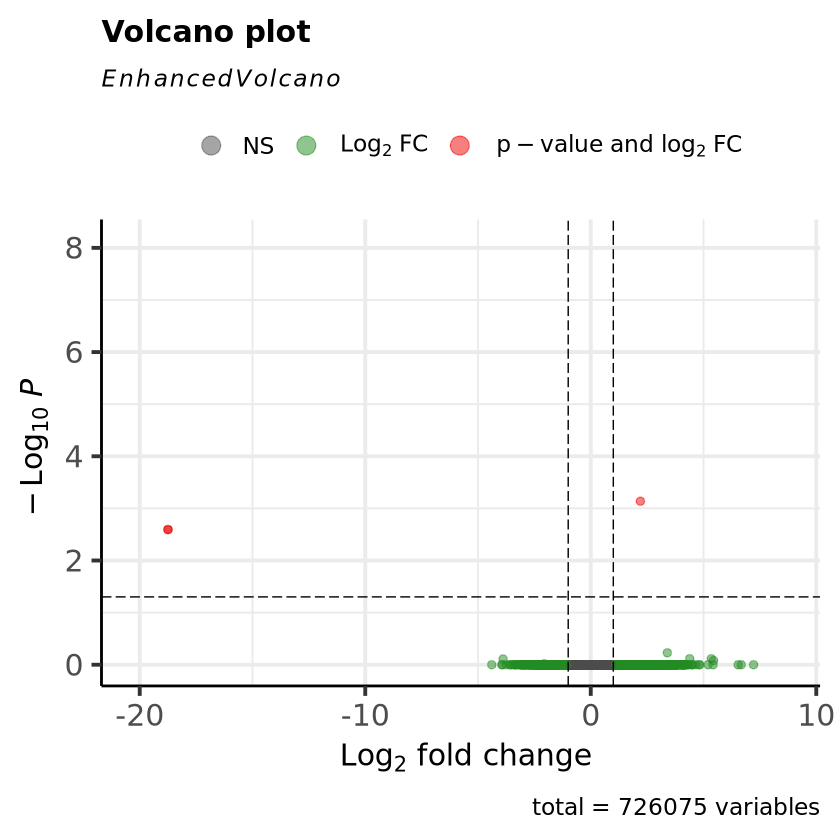

In [31]:
# phase 2 both vs. control
summary(results4)

EnhancedVolcano(results4, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)


out of 37610 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 1, 0.0027%
LFC < 0 (down)     : 1, 0.0027%
outliers [1]       : 0, 0%
low counts [2]     : 20, 0.053%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



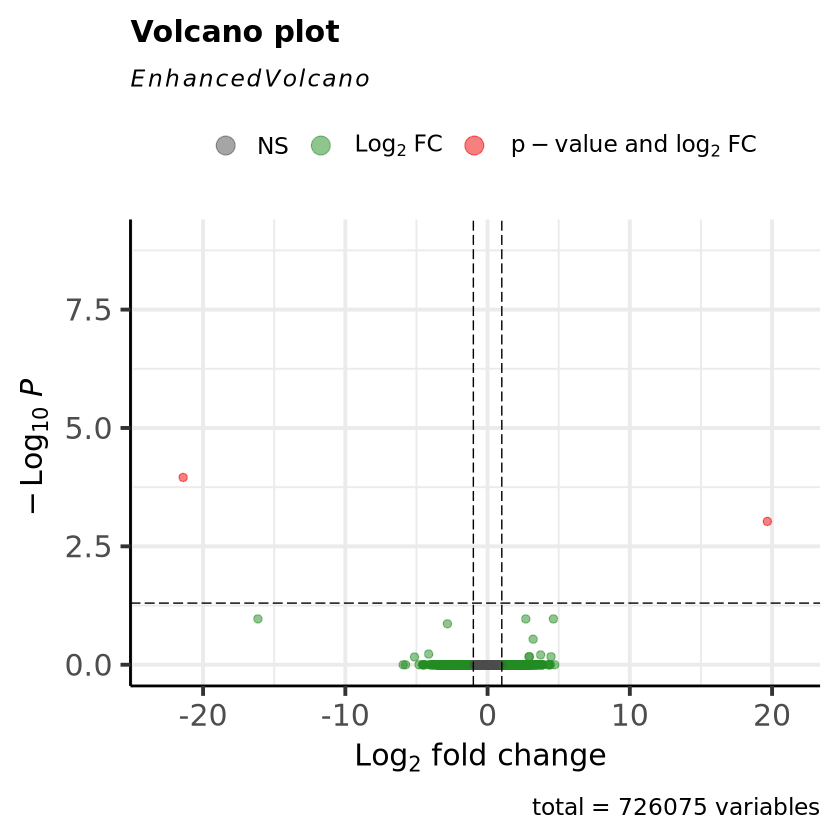

In [32]:
# phase 2 both vs. hypoxic
summary(results5)

EnhancedVolcano(results5, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

#### Given phase 2, effect of phase 1

In [33]:
# have to load tidyverse before using filter()
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::%within%() masks IRanges::%within%()
✖ dplyr::collapse()     masks IRanges::collapse()
✖ dplyr::combine()      masks Biobase::combine(), BiocGenerics::combine()
✖ dplyr::count()        masks matrixStats::count()
✖ dplyr::desc()         masks IRanges::desc()
✖ tidyr::expand()       masks S4Vectors::expand()
✖ dplyr::filter()       masks stats::filter()
✖ dplyr::first()        masks S4Vectors::first()
✖ dplyr::lag()          masks stats::lag()
✖ ggplot2::Position()   masks BiocGenerics::Position(), base::Position()
✖ purrr::reduce()       masks GenomicRanges::reduce(), IRanges::reduce()
✖ dplyr::rename()       masks S4Vectors::rename()
✖ lubridate::second()  

In [34]:
p2h_meta = filter(meta_data, meta_data$Phase2 == 'hypoxic')
p2h_meta

sample_ID,unique_ID,T1_code,T2_code,ID_code,T1_oxygen,T1_temp,Tank1,T2_oxygen,T2_temp,Tank2,Phase1,Phase2
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2018--BBO-BBO-B16-CV,BBO-BBO-B16,BBO,BBO,B16,hypoxic,ambient,O,hypoxic,ambient,O,hypoxic,hypoxic
2018--BBO-BBY-B27-CV,BBO-BBY-B27,BBO,BBY,B27,hypoxic,ambient,O,hypoxic,ambient,Y,hypoxic,hypoxic
2018--BBR-BBB-B50-CV,BBR-BBB-B50,BBR,BBB,B50,hypoxic,ambient,R,hypoxic,ambient,B,hypoxic,hypoxic
2018--BBR-BBG-B38-CV,BBR-BBG-B38,BBR,BBG,B38,hypoxic,ambient,R,hypoxic,ambient,G,hypoxic,hypoxic
2018--BBR-BBY-B26-CV,BBR-BBY-B26,BBR,BBY,B26,hypoxic,ambient,R,hypoxic,ambient,Y,hypoxic,hypoxic
2018--WBG-BBB-W56-CV,WBG-BBB-W56,WBG,BBB,W56,normoxic,ambient,G,hypoxic,ambient,B,control,hypoxic
2018--WBO-BBR-W03-CV,WBO-BBR-W03,WBO,BBR,W03,normoxic,ambient,O,hypoxic,ambient,R,control,hypoxic
2018--WBR-BBY-W25-CV,WBR-BBY-W25,WBR,BBY,W25,normoxic,ambient,R,hypoxic,ambient,Y,control,hypoxic
2018--WBY-BBV-W65-CV,WBY-BBV-W65,WBY,BBV,W65,normoxic,ambient,Y,hypoxic,ambient,V,control,hypoxic


### running DESeq2 on **META feature (e.g. genes)**

#### effects of phase 1, ingoring phase 2

In [25]:
# creating DESeq2 objext from the matrix, with the design = treatment (which has both phase 1 and phase 2 variables)
p1_dds <- DESeqDataSetFromMatrix(countData = fc_meta,
                              colData = meta_data, 
                              design = ~ Phase1)
p1_dds=DESeq(p1_dds)
resultsNames(p1_dds)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 607 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "Intercept"              "Phase1_control_vs_both" "Phase1_hypoxic_vs_both"
[4] "Phase1_warm_vs_both"

In [26]:
# specify contrasts (what treatments to compare)
contrast1 <- c("Phase1", "hypoxic", "control")
contrast2 <- c("Phase1", "both", "control")
contrast3 <- c("Phase1", "warm", "control")

In [33]:
# storing results in variables to call for EnhancedVolcano 

# Phase 1 hypoxic vs. control
results1 <- results(p1_dds, contrast = contrast1, alpha=0.05)

# Phase 1 both vs. control
results2 <- results(p1_dds, contrast = contrast2, alpha=0.05)

# Phase 1 warm vs. control
results3 <- results(p1_dds, contrast = contrast3, alpha=0.05)


out of 20323 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 290, 1.4%
low counts [2]     : 6, 0.03%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



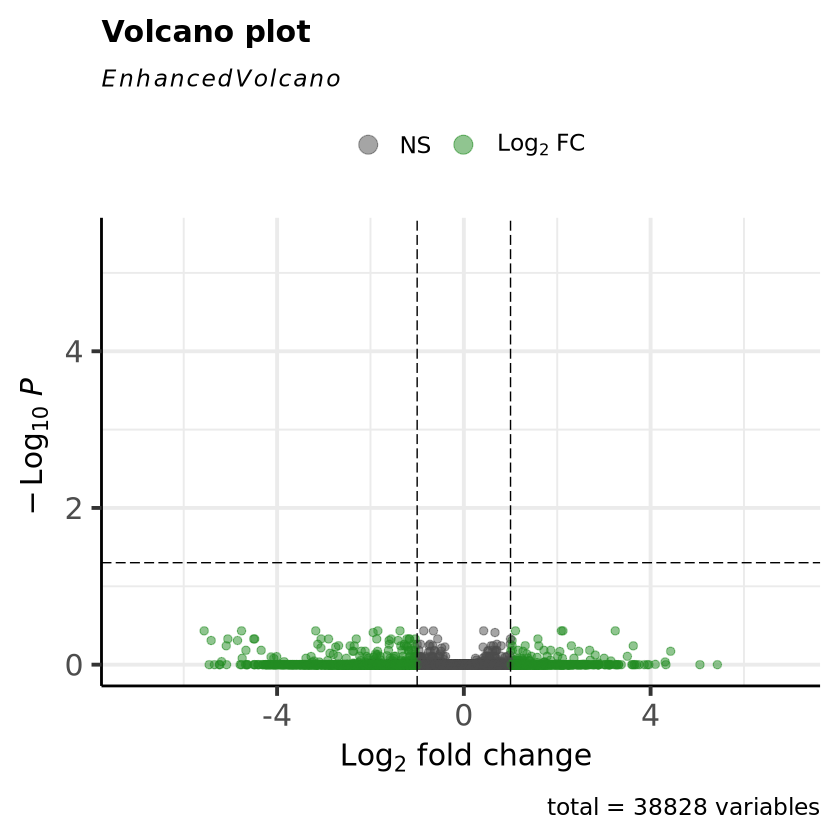

In [28]:
# phase 1 hypoxic vs. control
summary(results1)

EnhancedVolcano(results1, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)


out of 20323 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 290, 1.4%
low counts [2]     : 6, 0.03%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



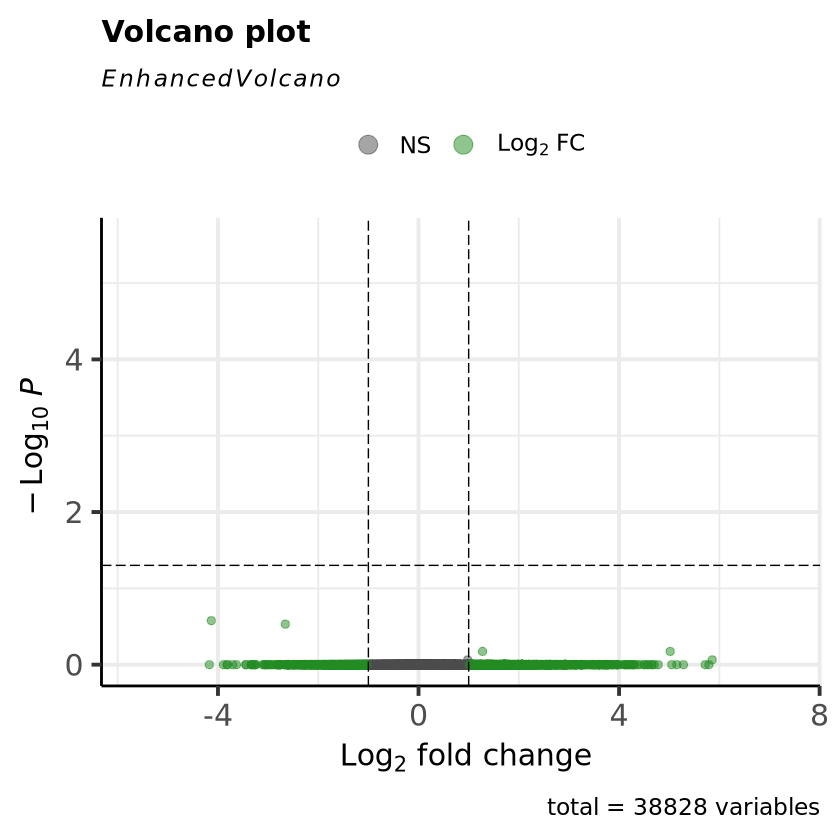

In [29]:
# phase 1 both vs. control
summary(results2)

EnhancedVolcano(results2, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)


out of 20323 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 658, 3.2%
LFC < 0 (down)     : 19, 0.093%
outliers [1]       : 290, 1.4%
low counts [2]     : 11976, 59%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



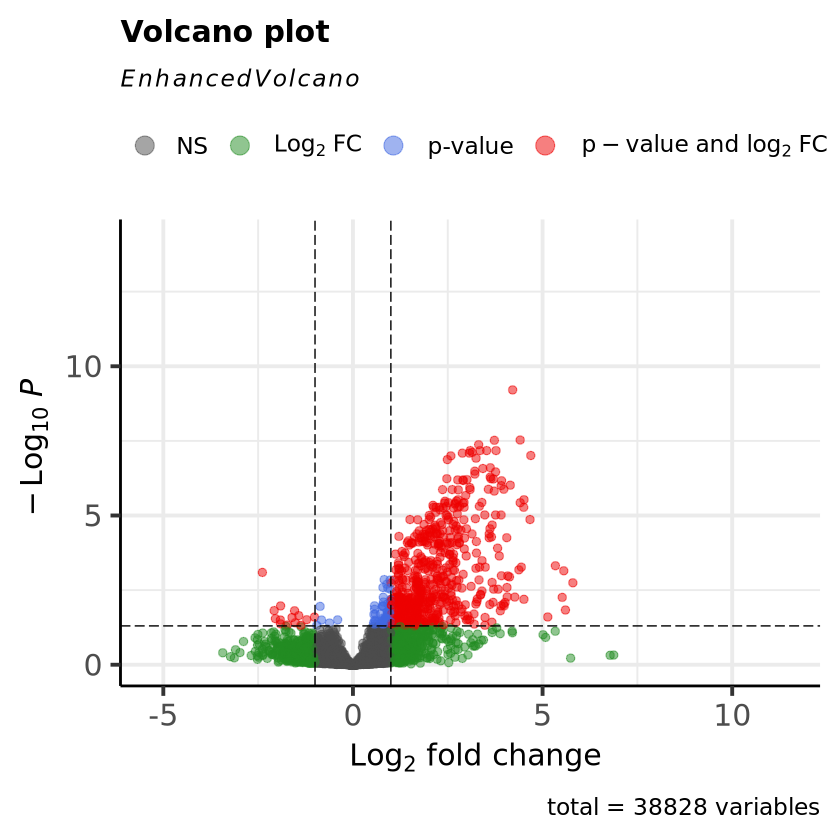

In [34]:
# phase 1 warm vs. control
summary(results3)

EnhancedVolcano(results3, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

okay so order of samples definitely matters - now seeing ~ 700 genes that are significant!!

for Log2FoldChange filtering (lfcThreshold argument in DESeq results function) - don't think this matters since our downstream analysis is for GSEA (gene set enrichment analysis; also don't think that filtering should be done post hoc either...)

In [53]:
# saving list of genes into csv file
write.csv(as.data.frame(results3), '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/significant_genes/FC_sig_p1wc.csv')

both htseq-counts and this featureCounts matrix were done on META features (e.g. genes), and had roughly the same number of genes in their matrix - so interesting that they produced wildly different results for the DESeq analysis...

part of me thinks that it's possible the sample names weren't matched up correctly the first time around with htseq-counts
